In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sympy import Symbol
import centrex_TlF as centrex
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from utils.plot_utils import set_fontsize

### Some initial setup of states and transitions to use

In [2]:
nprocs = 6

# Γ
Γ = 1.56e6*2*np.pi

# TlF temperature
T = 6.3

# Define all involved states

# ground state J levels
ground_Js = [0,2]

# excited state quantum numbers
excited_Js = [1]
excited_F1s = [1/2]
excited_Fs= [1]
excited_Ps = [-1]

# Settings for transitions

# min and max J level to look for mixing in the B state
excited_Jmin = 1
excited_Jmax = 2


# main laser transition R(0) F'=2 F1'=3/2

ground_main_approx = 1*centrex.CoupledBasisState(J=0,F1=1/2,F=0,mF=0,I1=1/2,I2=1/2,electronic_state='X', 
                                         P = (-1)**0, Omega = 0)
excited_main_approx = 1*centrex.CoupledBasisState(J=1,
                                          F1=1/2,
                                          F=1,
                                          mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
# ground laser J
laser_J = [0]

transitions = [{'ground main approx': ground_main_approx, 
                'excited main approx': excited_main_approx,
                'ground states approx': 1*centrex.states.generate_coupled_states_ground(laser_J),
                'excited states approx': 1*centrex.states.generate_coupled_states_excited(
                                                excited_Js, excited_Fs, excited_F1s, excited_Ps),
                'main polarization': np.array([0,0,1]),
                'polarizations': [np.array([0,0,1]), np.array([1,0,0])],
                'polarization symbols': [Symbol("Plz"), Symbol("Plx")],
                'Ω symbol': Symbol('Ωl', complex = True),
                'Δ symbol': Symbol('δl'),
                'description': "laser transition"
               }]

In [3]:
# specify states to combine into a single level 
# e.g. only decay to these states and not interested in population distribution there
slice_compact = np.s_[4:24]

### Specifying parameters and the ode function preamble
Allows for setting parameters to be time dependent (e.g. sin(t), cos(t))

In [4]:
# order of parameters in p
parameters = ['Ωl', 'δl', 'ωp', 'ϕp']

In [5]:
preamble = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tδl = p[2]
\t\tωp = p[3]
\t\tϕp = p[4]
\t\tΩlᶜ = conj(Ωl)

\t\tPl = sin(ωp*t + ϕp)
\t\tPlx = (1-Pl)/2
\t\tPlz = (1+Pl)/2
"""

In [6]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = Γ
odepars.ωp = Γ
odepars

odeParameters(Ωl: 9.80e+06, δl: 0.00e+00, ωp: 9.80e+06, ϕp: 0.00e+00)

## Start calculations for Hamiltonian and transitions

In [7]:
%%time 
ground_states_approx = centrex.states.generate_coupled_states_ground(ground_Js)
excited_states_approx = centrex.states.generate_coupled_states_excited(excited_Js, excited_Fs, 
                                                                       excited_F1s, excited_Ps)

ground_states, excited_states, QN, H_int, V_ref_int = centrex.hamiltonian.generate_total_reduced_hamiltonian(
                                            ground_states_approx, excited_states_approx)

Wall time: 6.73 s


In [8]:
%%time
couplings = []
for transition in transitions:
    coupling = centrex.couplings.generate_coupling_field(
                                        transition['ground main approx'],
                                        transition['excited main approx'],
                                        transition['ground states approx'],
                                        transition['excited states approx'],
                                        H_int, QN, V_ref_int, 
                                        pol_main = transition['main polarization'],
                                        pol_vec = transition['polarizations'],
                                        nprocs = nprocs)
    couplings.append(coupling)

Wall time: 3.57 s


In [9]:
%%time
H_symbolic = centrex.lindblad.generate_total_symbolic_hamiltonian(QN, H_int, couplings, transitions, 
                                                                slice_compact = slice_compact)

Wall time: 156 ms


In [10]:
%%time
C_array = centrex.couplings.collapse_matrices(QN, ground_states, excited_states, gamma = Γ, 
                                            slice_compact = slice_compact)
system = centrex.lindblad.generate_system_of_equations_symbolic(H_symbolic, C_array, progress = False, fast = True)

Wall time: 1.2 s


In [11]:
%%time
# convert matrix to system of equations code
code_lines = centrex.lindblad.system_of_equations_to_lines(system, nprocs = nprocs)

Wall time: 4.73 s


# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [12]:
# import julia
# julia.install()

In [13]:
from julia import Main
centrex.lindblad.initialize_julia(nprocs = nprocs)

_ = centrex.lindblad.generate_ode_fun_julia(preamble, code_lines)

# generate initial conditions
ρ_ini = centrex.utils.generate_thermal_J(ground_Js, len(excited_states), T, normalized = True)
centrex.lindblad.setup_variables_julia(Γ, ρ_ini)
odepars.generate_p_julia()

Initialized Julia with 6 processes


### Initial condition setup

In [14]:
J0_pop_before_RC = np.array([0.05334403+0.j, 0.05334403+0.j, 0.05334403+0.j, 0.05334403+0.j])

In [15]:
ρ_ini = np.zeros(system.shape, dtype = 'complex')
np.fill_diagonal(ρ_ini[:4,:4], J0_pop_before_RC)
print(np.diag(ρ_ini))

centrex.lindblad.setup_variables_julia(Γ, ρ_ini)

[0.05334403+0.j 0.05334403+0.j 0.05334403+0.j 0.05334403+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]


### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [16]:
Main.eval("""
tspan = (0.0, 30e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [17]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-7, reltol = 1e-4, progress = false);
tmp = 0
""");

Wall time: 8.77 s


0

In [18]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

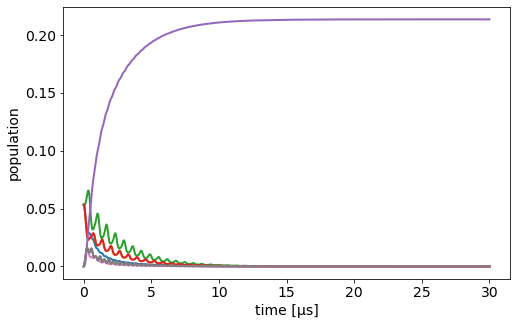

In [19]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(0,len(pop_results)):
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [20]:
print(f'{np.trapz(pop_results[-len(excited_states):].sum(axis = 0), t_array)*Main.Γ}')

0.6386876054618812


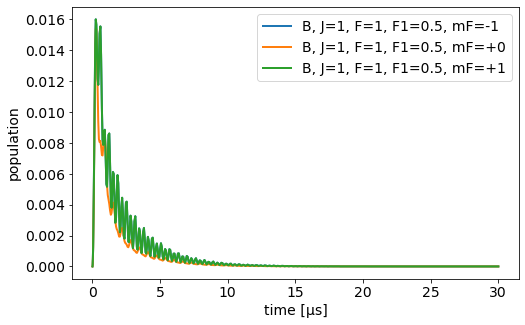

In [21]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx >= H_symbolic.shape[0] - len(excited_states):
        s = QN[idx+centrex.utils.J_levels(2)-1].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [22]:
J0_pop_after_rc = np.array([0.16855735, 0.06941865, 0.0716151 , 0.06941859])

In [23]:
ρ_rc = np.zeros(ρ_ini.shape, dtype = complex)
np.fill_diagonal(ρ_rc[:4,:4], J0_pop_after_rc)
Main.ρ_rc = ρ_rc

In [24]:
Main.eval("""
prob_rc = ODEProblem(Lindblad_rhs!,ρ_rc,tspan,p)
""");

In [25]:
%%time
Main.eval("""
@time sol_rc = solve(prob_rc, Tsit5(), abstol = 1e-7, reltol = 1e-4, progress = false);
tmp = 0
""");

Wall time: 15 ms


0

In [26]:
ut = np.array(Main.eval("sol_rc[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol_rc.t")

In [27]:
print(f'{np.trapz(pop_results[-len(excited_states):].sum(axis = 0), t_array)*Main.Γ}')

1.134594480450065


In [28]:
RC_on = np.trapz(np.real(np.einsum('jji->ji', 
                           np.array(Main.eval("sol_rc.u[:]")).T))[-len(excited_states):].sum(axis = 0), 
                 Main.eval('sol_rc.t'))
RC_off = np.trapz(np.real(np.einsum('jji->ji', 
                           np.array(Main.eval("sol.u[:]")).T))[-len(excited_states):].sum(axis = 0), 
                 Main.eval('sol.t'))
print(f'ratio RC on/off : {RC_on / RC_off:.2f}')

ratio RC on/off : 1.78


## Scan Rabi Rate

In [29]:
Main.eval("""
tspan = (0.0, 30e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [30]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_1D(odepars, 'Ωl', np.linspace(0,1.5*Γ,801))

In [31]:
# only save the integral of the excited state population of each trajectory
start = H_symbolic.shape[0] - len(excited_states) + 1
stop = start + len(excited_states)
centrex.lindblad.setup_state_integral_calculation(list(range(start, stop)))

In [32]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
ens_prob_rc = EnsembleProblem(prob_rc, prob_func = prob_func, output_func = output_func);
""");

In [33]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-11, reltol = 1e-8)
sim.elapsedTime
""")

20.1826101

In [34]:
Main.eval("""
@time sim_rc = solve(ens_prob_rc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-11, reltol = 1e-8)
sim_rc.elapsedTime
""")

3.6670046

<ipython-input-35-18f4ea3804a8>:2: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc) / np.asarray(Main.sim), lw = 2)


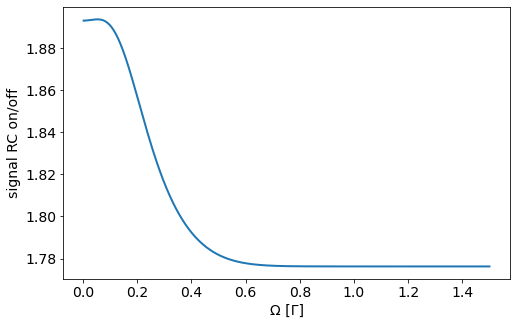

In [35]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc) / np.asarray(Main.sim), lw = 2)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('signal RC on/off')

set_fontsize(ax, 14)

In [36]:
val = np.asarray(Main.sim_rc) / np.asarray(Main.sim)
val = val[~np.isnan(val)]
print(f"difference => {(val.max() - val.min())/val.max()*100:.2f}%")

difference => 6.20%


<ipython-input-36-02c076ff67e9>:1: RuntimeWarning: invalid value encountered in true_divide
  val = np.asarray(Main.sim_rc) / np.asarray(Main.sim)
